In [ ]:
# libraries
import os
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# models
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
%run "/content/gdrive/MyDrive/Colab Notebooks/UNIR/2_Cuatrimestre/TFM/3_utils/PY_utils.ipynb"

### 1. Load images from dataset
The dataset is split in train (80%), validation (10%) and test (10%)

In [ ]:
# unzip file
!unzip "/content/gdrive/MyDrive/Colab Notebooks/UNIR/2_Cuatrimestre/TFM/1_modeling/dataset_auxiliary.zip"

Streaming output truncated to the last 5000 lines.
  inflating: validation/angry/image0004345.jpg  
  inflating: validation/angry/image0004445.jpg  
  inflating: validation/angry/image0004642.jpg  
  inflating: validation/angry/image0004816.jpg  
  inflating: validation/angry/image0004952.jpg  
  inflating: validation/angry/image0005156.jpg  
  inflating: validation/angry/image0005347.jpg  
  inflating: validation/angry/image0005773.jpg  
  inflating: validation/angry/image0005935.jpg  
  inflating: validation/angry/image0006020.jpg  
  inflating: validation/angry/image0006195.jpg  
  inflating: validation/angry/image0006211.jpg  
  inflating: validation/angry/image0006224.jpg  
  inflating: validation/angry/image0006484.jpg  
  inflating: validation/angry/image0006895.jpg  
  inflating: validation/angry/image0007604.jpg  
  inflating: validation/angry/image0007783.jpg  
  inflating: validation/angry/image0007805.jpg  
  inflating: validation/angry/image0007904.jpg  
  inflating: valid

In [ ]:
# directories
ROOT = "/content/gdrive/MyDrive/Colab Notebooks/UNIR/2_Cuatrimestre/TFM/1_modeling/"
TRAIN_PATH = "/content/train"
VAL_PATH = "/content/validation"
TEST_PATH = "/content/test"

# target size of images
TARGET_SIZE = 48

# batch size
BATCH_SIZE = 128

# map labels to emotions
map_emotions = {0: "angry", 1:"disgust", 2:"fear", 3: "happy",
                4: "neutral", 5: "sad", 6:"surprise"}

### 2. Load and transform dataset
Images are transformed from color (NxNx3) to grayscale (NxNx1) and scaled to (0, 1). One-hot encoding is applied to labels. Data augmentation technique is used.

In [ ]:
# load dataset
train_set = data_loader_tf_dataset(TRAIN_PATH, BATCH_SIZE, TARGET_SIZE, augmentation=True, shuffle=True)
val_set = data_loader_tf_dataset(VAL_PATH, BATCH_SIZE, TARGET_SIZE, augmentation=False, shuffle=False)
test_set = data_loader_tf_dataset(TEST_PATH, BATCH_SIZE, TARGET_SIZE, augmentation=False, shuffle=False)

Found 41625 files belonging to 7 classes.
Found 5344 files belonging to 7 classes.
Found 5066 files belonging to 7 classes.


### 3. Training
To train the classifier we utilize a neural network architecture considering  convolutional and fully connected layers.

#### Define CNN architecture

In [ ]:
# define architecture
DROPOUT = 0.4
OUTPUT_SIZE = len(map_emotions)

# define sequential model
model = keras.models.Sequential()
# 1 convolution layer
model.add(layers.BatchNormalization(input_shape=(TARGET_SIZE, TARGET_SIZE, 1)))
model.add(layers.Conv2D(32, (3, 3), input_shape=(TARGET_SIZE, TARGET_SIZE, 1)))
model.add(layers.Activation("relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(DROPOUT))
# 2 convolution layer
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation("relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(3, 2))
model.add(layers.Dropout(DROPOUT))
# 3 convolution layer
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation("relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(3, 2))
model.add(layers.Dropout(DROPOUT))
# 4 convolution layer
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation("relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(3, 2))
model.add(layers.Dropout(DROPOUT))
# flatten
model.add(layers.Flatten())
# 1 fully connected hidden layer
model.add(layers.Dense(units=1024))
model.add(layers.Activation("relu"))
model.add(layers.Dropout(DROPOUT + 0.1))
model.add(layers.BatchNormalization())
# 2 fully connected hidden layer
model.add(layers.Dense(units=512))
model.add(layers.Activation("relu"))
model.add(layers.Dropout(DROPOUT + 0.1))
model.add(layers.BatchNormalization())
# output layer
model.add(layers.Dense(units=OUTPUT_SIZE, activation="softmax"))

In [ ]:
# architecture summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 48, 48, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)       

#### Compile and train classifier

In [ ]:
# define loss, optimizer and monitoring metrics
loss_function = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.AdamW()
metrics = [keras.metrics.CategoricalAccuracy(name="Accuracy"),
           keras.metrics.AUC(curve="ROC", name="AUC_ROC", multi_label=True),
           keras.metrics.AUC(curve="PR", name="AUC_PR", multi_label=True)]

# class weights
class_weights = {0: 1, 1: 1.2, 2: 1.2, 3: 1, 4: 0.9, 5: 1.1, 6: 1}

# compile model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=metrics)

In [ ]:
# define number of epochs and batch size
N_EPOCHS = 200

# train classifier
history = model.fit(train_set, epochs=N_EPOCHS,
                    batch_size=BATCH_SIZE, validation_data=val_set,
                    class_weight=class_weights)

Epoch 1/200
326/326 [==============================] - 43s 83ms/step - loss: 2.1652 - Accuracy: 0.2079 - AUC_ROC: 0.5482 - AUC_PR: 0.1642 - val_loss: 4.1463 - val_Accuracy: 0.1815 - val_AUC_ROC: 0.5231 - val_AUC_PR: 0.1550
Epoch 2/200
326/326 [==============================] - 6s 17ms/step - loss: 1.8886 - Accuracy: 0.2652 - AUC_ROC: 0.6065 - AUC_PR: 0.1966 - val_loss: 2.0705 - val_Accuracy: 0.2678 - val_AUC_ROC: 0.6368 - val_AUC_PR: 0.2203
Epoch 3/200
326/326 [==============================] - 5s 15ms/step - loss: 1.8287 - Accuracy: 0.2966 - AUC_ROC: 0.6410 - AUC_PR: 0.2215 - val_loss: 1.8049 - val_Accuracy: 0.3086 - val_AUC_ROC: 0.6899 - val_AUC_PR: 0.2736
Epoch 4/200
326/326 [==============================] - 6s 17ms/step - loss: 1.7846 - Accuracy: 0.3230 - AUC_ROC: 0.6678 - AUC_PR: 0.2455 - val_loss: 1.6439 - val_Accuracy: 0.3746 - val_AUC_ROC: 0.7297 - val_AUC_PR: 0.3178
Epoch 5/200
326/326 [==============================] - 6s 19ms/step - loss: 1.7421 - Accuracy: 0.3466 - AUC_ROC

#### Save model

In [ ]:
# save model
MODEL_NAME = "3_aux_da"
SAVE_PATH = ROOT + "{}/".format(MODEL_NAME)
FILE_NAME = MODEL_NAME + ".h5"
model.save(SAVE_PATH + FILE_NAME, overwrite=True, save_format="h5")

### 4. Metrics

#### Learning curves

In [ ]:
# save learning curves
FILE_NAME = MODEL_NAME + "_lc.csv"
df = pd.DataFrame(history.history)
df.to_csv(SAVE_PATH + FILE_NAME, index=False)

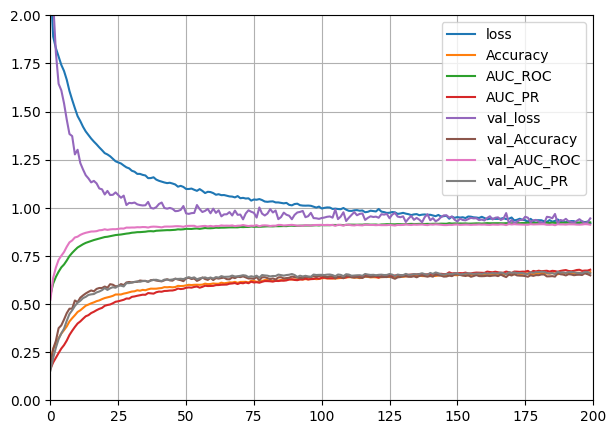

In [ ]:
# learning curves
learning_curve(history, N_EPOCHS)

#### Confusion matrix: validation set


42/42 [==============================] - 0s 3ms/step
Matrix de confusión



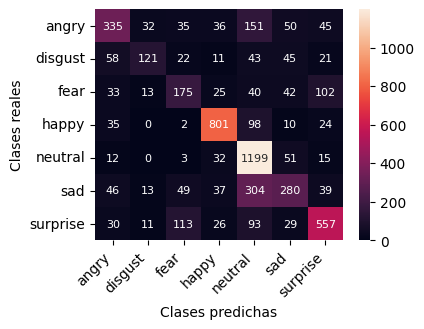



Reporte clasificacion:

              precision    recall  f1-score   support

       angry       0.61      0.49      0.54       684
     disgust       0.64      0.38      0.47       321
        fear       0.44      0.41      0.42       430
       happy       0.83      0.83      0.83       970
     neutral       0.62      0.91      0.74      1312
         sad       0.55      0.36      0.44       768
    surprise       0.69      0.65      0.67       859

    accuracy                           0.65      5344
   macro avg       0.63      0.58      0.59      5344
weighted avg       0.65      0.65      0.63      5344



In [ ]:
# get true and predicted labels
confusion_matrix_report(model, val_set, map_emotions)

#### Confusion matrix: test set

40/40 [==============================] - 0s 4ms/step
Matrix de confusión



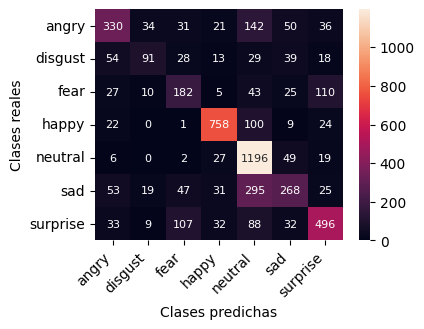



Reporte clasificacion:

              precision    recall  f1-score   support

       angry       0.63      0.51      0.56       644
     disgust       0.56      0.33      0.42       272
        fear       0.46      0.45      0.46       402
       happy       0.85      0.83      0.84       914
     neutral       0.63      0.92      0.75      1299
         sad       0.57      0.36      0.44       738
    surprise       0.68      0.62      0.65       797

    accuracy                           0.66      5066
   macro avg       0.63      0.58      0.59      5066
weighted avg       0.65      0.66      0.64      5066



In [ ]:
# get true and predicted labels
confusion_matrix_report(model, test_set, map_emotions)